# AC215 Fall 2021 Project - Team KKST
## Project: Image Captioning

Team members: 
- Shih-Yi Tseng 
- Steve Knapp 
- Al-Muataz Khalil
- Matthew Stewart 
- Ed Bayes

## About this notebook
In this notebook, we trained a **prefix transformer model** for image captioning on the Flickr 8k and MS-COCO datasets, and then performed distillation of the model.


## Set-up

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# !pip install transformers

     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=03cb1cbe7e1aeb8652ee1d1d6ed7ccd8c151ed828bc7d2e389bb424548cd7a6c
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a7lj6tmz
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-a7lj6tmz
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=3a030b9c2301f90fb2300c7ba4e001eb22c85879c3281f49cae572b1305cac83
  Stored in directory: /tmp/pip-ephem-wheel-cache-2cdodesw/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import os
from os.path import join  
import requests
import zipfile
import tarfile
import shutil
import random
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import TextVectorization

# Colab auth
from google.colab import auth
from google.cloud import storage

# torch and clip
import torch
import clip
from PIL import Image

# bleu score
from nltk.translate.bleu_score import sentence_bleu

### Verify Set-up

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.7.0
keras version 2.7.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sun Dec 12 14:51:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Utilities

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    img_path = FIMAGES + '/' + item[0]
    image = cv2.imread(img_path)
    data_list_with_metrics.append((img_path,image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'path': data_list_with_metrics[:, 0],
    'height': data_list_with_metrics[:, 1],
    'width': data_list_with_metrics[:, 2],
    'size': data_list_with_metrics[:, 3],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## Data Sets

### Download and Read In Flickr8K Datasets from GCP Bucket

In [ ]:
# Build paths for data and models
CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH,'data')
MODEL_PATH = os.path.join(CURRENT_PATH,'model')

if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)
if not os.path.exists(MODEL_PATH):
  os.mkdir(MODEL_PATH)

In [ ]:
# FLICKR data
# download from GCP bucket
start_time = time.time()
download_file("https://storage.googleapis.com/ac215-project/flickr_data.zip", base_path=DATA_PATH + '/flickr', extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

# read-in
FLICKR_PATH = DATA_PATH + '/flickr'
fcaps = pd.read_csv(os.path.join(FLICKR_PATH,"captions.txt"))

Download execution time (mins) 0.2064449707667033


### Explore Data Shape

In [ ]:
# explore the captions
print("Number of rows:",fcaps.shape[0])
print("Unique image names:",len(pd.unique(fcaps['image'])))
print("Unique captions:",len(pd.unique(fcaps['caption'])))
print("Unique rows:",len(fcaps.value_counts()))
print("Head:")
fcaps.head()

Number of rows: 40455
Unique image names: 8091
Unique captions: 40201
Unique rows: 40445
Head:


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# explore the images
FIMAGES = FLICKR_PATH + '/Images'
print("Counting all .png files in: " + FIMAGES)
x=0
for files in os.listdir(FIMAGES):
    if files.endswith('.jpg'):
        x+=1
print(x)

Counting all .png files in: /content/data/flickr/Images
8091


### Sample Images

1000268201_693b08cb0e.jpg
A girl going into a wooden building .


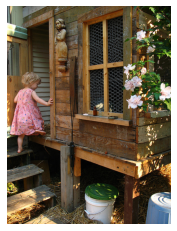

In [ ]:
# retrieve an image and caption
this_img = fcaps.iloc[1][0]
print(this_img)
print(fcaps.iloc[1][1])
image = cv2.imread(FIMAGES + '/' + this_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

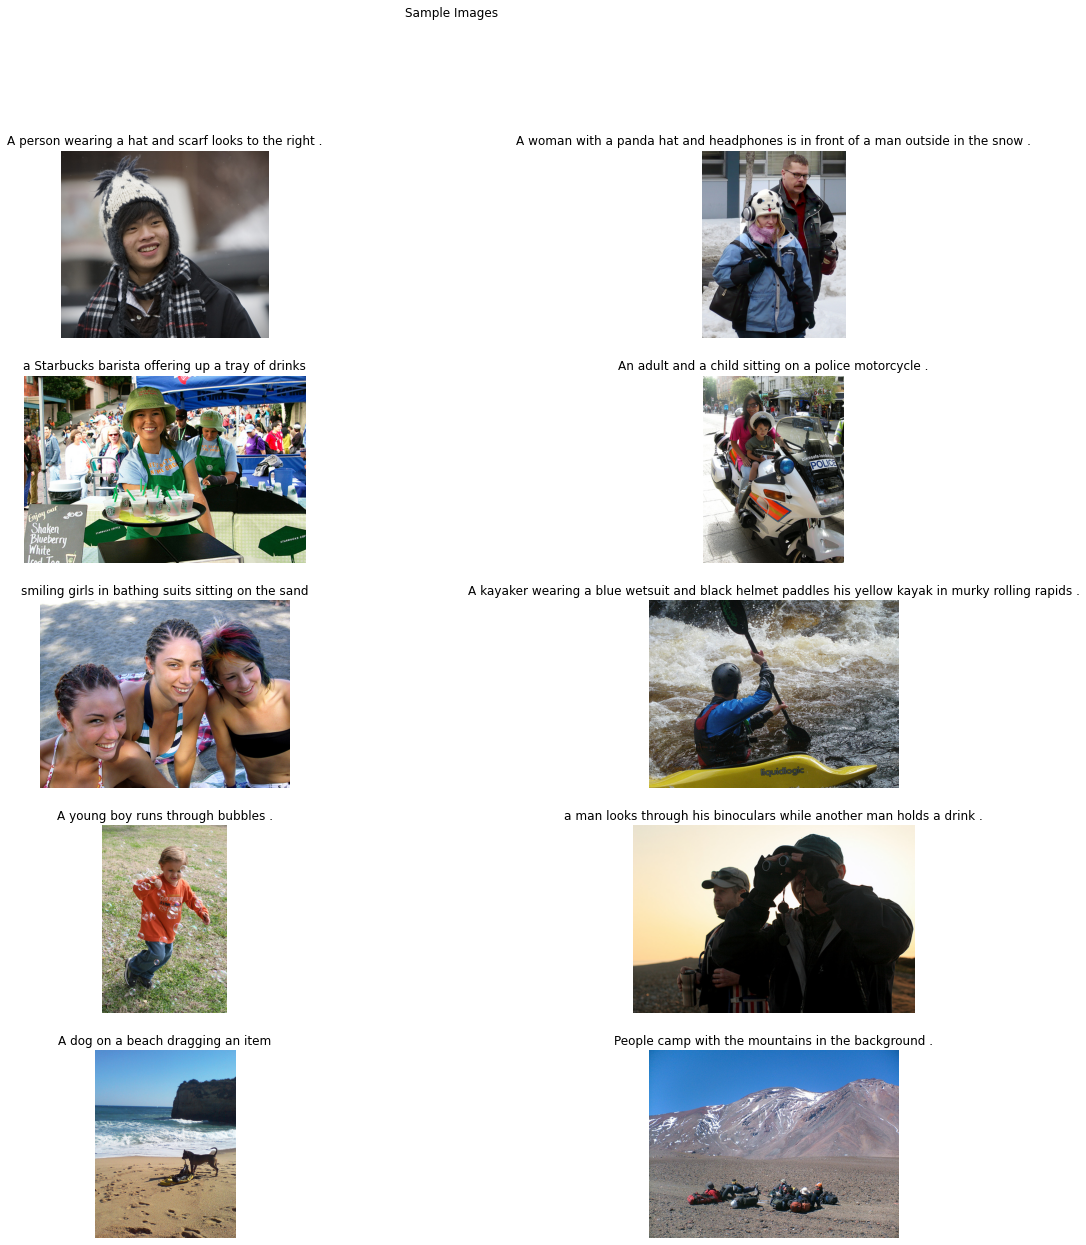

In [ ]:
# retrieve a sample of images and captions
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(pd.unique(fcaps['image']))-1, size=10)

fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(5,2,i+1)
    axs.set_title(fcaps.iloc[img_idx][1])
    # Read image
    image = cv2.imread(FIMAGES + '/' + fcaps.iloc[img_idx][0])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### Data Set Metrics

In [ ]:
# Compute dataset metrics
# only do this for unique images (each image has multiple possible captions)
u_images = pd.unique(fcaps['image'])
u_images_df = pd.DataFrame({
    'image': u_images,
    'ind': range(0,len(u_images))
    })
u_images_df["ind"] = u_images_df["ind"].astype(str)
u_images_list = u_images_df.values.tolist()
compute_dataset_metrics(u_images_list)

## Download COCO dataset

In [ ]:
# Download COCO 2014 caption annotation files
COCO_PATH = os.path.join(DATA_PATH, 'coco')
annotation_folder = os.path.join(COCO_PATH,'annotations')
image_folder = os.path.join(COCO_PATH,'train2014')

if not os.path.exists(COCO_PATH):
  os.mkdir(COCO_PATH)

# Download annotation
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=COCO_PATH,
                                          origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract=True)
os.remove(annotation_zip)

# Download training images
image_zip = tf.keras.utils.get_file('train2014.zip',
                                    cache_subdir=COCO_PATH,
                                    origin='http://images.cocodataset.org/zips/train2014.zip',
                                    extract=True)
os.remove(image_zip)

# Download validation images
val_image_zip = tf.keras.utils.get_file('val2014.zip',
                                    cache_subdir=COCO_PATH,
                                    origin='http://images.cocodataset.org/zips/val2014.zip',
                                    extract=True)
os.remove(val_image_zip)


6645022720/6645013297 [==============================] - 141s 0us/step


In [ ]:
# load annotation for training data
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# load annotation for validation data
val_annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_val2014.json'
with open(val_annotation_file, 'r') as f:
    annotations_val = json.load(f)

In [ ]:
annotations['annotations'][:5]

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340}]

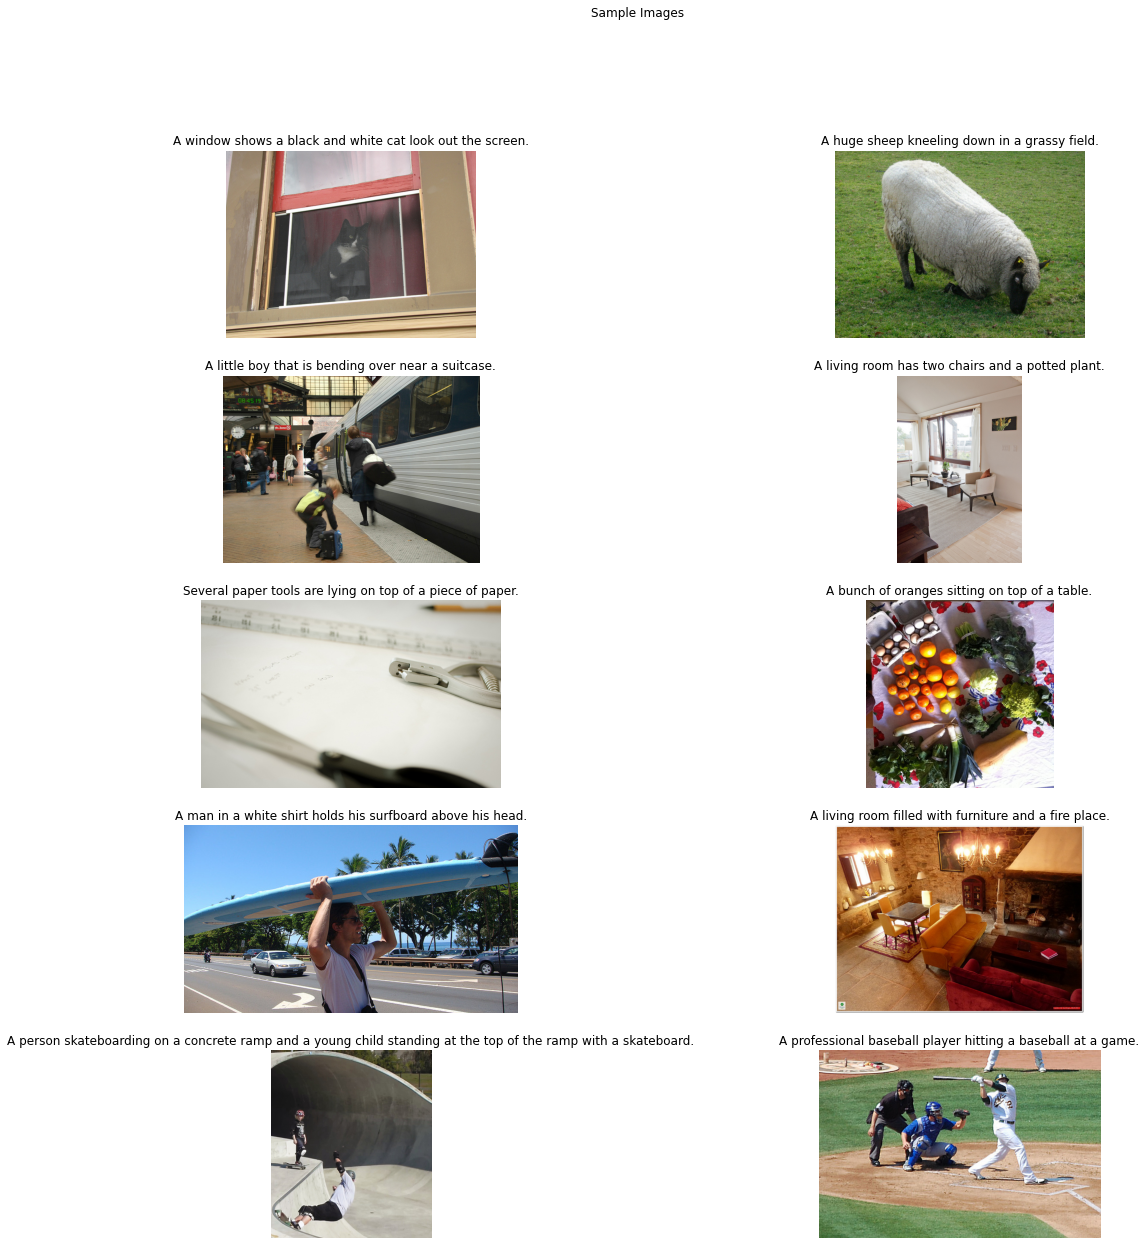

In [ ]:
# show example images and caption from COCO dataset
image_samples = np.random.randint(0,high=len(annotations['annotations']), size=10)
IMAGE_PATH_COCO = os.path.join(COCO_PATH, 'train2014')

fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(5,2,i+1)
    axs.set_title(annotations['annotations'][img_idx]['caption'])
    # Read image
    image = cv2.imread(os.path.join(IMAGE_PATH_COCO, 'COCO_train2014_' + '%012d.jpg' % (annotations['annotations'][img_idx]['image_id'])))
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

## Build Data Pipelines

### Set up hyperparameters


In [ ]:
# Vocabulary size
VOCAB_SIZE = 15000
# Made up length for the transformed image feature
IMAGE_LENGTH = 16
# Fixed length allowed for any sequence
SEQ_LENGTH = 25
# Number of attention heads
NUM_HEADS = 10
# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
# Per-layer units in the feed-forward network
FF_DIM = EMBED_DIM*4
# Number of encoder blocks
NUM_ENC_LAYERS = 2
# Number of decoder blocks
NUM_DEC_LAYERS = 6
# Other training parameters
BATCH_SIZE = 128
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

### Preprocess images: feature extraction with CLIP

#### Download openAI CLIP model 

We use the image encoder of CLIP model as the feature extractor, which output a 512-dim embedding for images that was trained with contrastive loss to match with text description of that image.

Read about CLIP: https://openai.com/blog/clip/

Github: https://github.com/openai/CLIP

In [ ]:
# load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 261MiB/s]


#### Image feature extraction with CLIP (for first time processing)

We transformed the images into embedded features and save them as npy files, which we will load directly during training. This will save the inference time for embedding and speed up training process.

Skip to the next section "Load pre-processed image features extracted by CLIP" if the features have been extracted and saved previously.

In [ ]:
## Extract image features using CLIP for Flickr dataset
IMAGE_PATH = os.path.join(FLICKR_PATH, 'Images')
EMBED_PATH = os.path.join(FLICKR_PATH, 'Embed')

if not os.path.exists(EMBED_PATH):
  os.mkdir(EMBED_PATH)

image_list = os.listdir(IMAGE_PATH)

for img in tqdm(image_list):
  img_path = os.path.join(IMAGE_PATH, img)
  image = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)

  with torch.no_grad():
    embedded_img = clip_model.encode_image(image).cpu().numpy()
  
  np.save(os.path.join(EMBED_PATH, img)[:-4]+".npy", embedded_img)



In [ ]:
## Extract image features using CLIP for COCO train dataset
IMAGE_PATH_COCO = os.path.join(COCO_PATH, 'train2014')
EMBED_PATH_COCO = os.path.join(COCO_PATH, 'Embed')

if not os.path.exists(EMBED_PATH_COCO):
  os.mkdir(EMBED_PATH_COCO)

image_list = os.listdir(IMAGE_PATH_COCO)

for img in tqdm(image_list):
  img_path = os.path.join(IMAGE_PATH_COCO, img)
  image = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)

  with torch.no_grad():
    embedded_img = clip_model.encode_image(image).cpu().numpy()
  
  np.save(os.path.join(EMBED_PATH_COCO, img)[:-4]+".npy", embedded_img)


In [ ]:
## Extract image features using CLIP for COCO dataset
IMAGE_PATH_COCO_VAL = os.path.join(COCO_PATH, 'val2014')
EMBED_PATH_COCO_VAL = os.path.join(COCO_PATH, 'Embed_val')

if not os.path.exists(EMBED_PATH_COCO_VAL):
  os.mkdir(EMBED_PATH_COCO_VAL)

image_list = os.listdir(IMAGE_PATH_COCO_VAL)

for img in tqdm(image_list):
  img_path = os.path.join(IMAGE_PATH_COCO_VAL, img)
  image = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)

  with torch.no_grad():
    embedded_img = clip_model.encode_image(image).cpu().numpy()
  
  np.save(os.path.join(EMBED_PATH_COCO_VAL, img)[:-4]+".npy", embedded_img)

In [ ]:
# !zip -r /content/Flickr8k_image_feature_CLIP_ViTB16.zip /content/data/flickr/Embed
# !zip -r /content/COCO_train2014_image_feature_CLIP_ViTB16.zip /content/data/coco/Embed
# !zip -r /content/COCO_val2014_image_feature_CLIP_ViTB16.zip /content/data/coco/Embed_val

#### Load pre-processed image features extracted by CLIP 

In [ ]:
feature_url_flickr = 'https://storage.googleapis.com/ac215-project/Flickr8k_image_feature_CLIP_ViTB16.zip'
feature_url_COCOtrain = 'https://storage.googleapis.com/ac215-project/COCO_train2014_image_feature_CLIP_ViTB16.zip'
feature_url_COCOval = 'https://storage.googleapis.com/ac215-project/COCO_val2014_image_feature_CLIP_ViTB16.zip'

IMAGE_PATH_flickr = os.path.join(FLICKR_PATH, 'Images')
IMAGE_PATH_COCO = os.path.join(COCO_PATH, 'train2014')
IMAGE_PATH_COCO_VAL = os.path.join(COCO_PATH, 'val2014')

EMBED_PATH_flickr = os.path.join(FLICKR_PATH, 'Embed')
EMBED_PATH_COCO = os.path.join(COCO_PATH, 'Embed')
EMBED_PATH_COCO_VAL = os.path.join(COCO_PATH, 'Embed_val')

if not os.path.exists(EMBED_PATH_flickr):
  os.mkdir(EMBED_PATH_flickr)

if not os.path.exists(EMBED_PATH_COCO):
  os.mkdir(EMBED_PATH_COCO)

if not os.path.exists(EMBED_PATH_COCO_VAL):
  os.mkdir(EMBED_PATH_COCO_VAL)

start_time = time.time()
download_file(feature_url_flickr, base_path=EMBED_PATH_flickr, extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)


start_time = time.time()
download_file(feature_url_COCOtrain, base_path=EMBED_PATH_COCO, extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)


start_time = time.time()
download_file(feature_url_COCOval, base_path=EMBED_PATH_COCO_VAL, extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

### Preprocess text: tokenization

First we combine all captions for the two datasets

In [ ]:
## Combine image feature and caption into list
# Flickr
fcaps_list = [(img[:-4]+".npy", "<start> " + cap + " <end>") for img, cap in zip(fcaps['image'].values.tolist(), fcaps['caption'].values.tolist())]
all_captions_f = [itm[1] for itm in fcaps_list]
for i in range(2):
    print(fcaps_list[i])

# COCO
ccaps_list = [('COCO_train2014_' + '%012d.npy' % (val['image_id']), "<start> " + val['caption'] + " <end>") for val in annotations['annotations']]
all_captions_c = [itm[1] for itm in ccaps_list]
for i in range(2):
    print(ccaps_list[i])

ccaps_list_val = [('COCO_val2014_' + '%012d.npy' % (val['image_id']), "<start> " + val['caption'] + " <end>") for val in annotations_val['annotations']]
all_captions_v = [itm[1] for itm in ccaps_list_val]
for i in range(2):
    print(ccaps_list_val[i])

# Combine
combined_caption = all_captions_f.copy()
combined_caption.extend(all_captions_c)
combined_caption.extend(all_captions_v)

('1000268201_693b08cb0e.npy', '<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>')
('1000268201_693b08cb0e.npy', '<start> A girl going into a wooden building . <end>')
('COCO_train2014_000000318556.npy', '<start> A very clean and well decorated empty bathroom <end>')
('COCO_train2014_000000116100.npy', '<start> A panoramic view of a kitchen and all of its appliances. <end>')
('COCO_val2014_000000203564.npy', '<start> A bicycle replica with a clock as the front wheel. <end>')
('COCO_val2014_000000179765.npy', '<start> A black Honda motorcycle parked in front of a garage. <end>')


In [ ]:
def custom_standardization(input_string):
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# create text vectorization
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization
)
vectorization.adapt(combined_caption)

# get index_word and word_index conversion
vocab = vectorization.get_vocabulary()
index_word = dict(zip(range(len(vocab)), vocab))
word_index = dict(zip(vocab, range(len(vocab))))

# vectorize all captions
cap_vector_f = vectorization(all_captions_f)
cap_vector_c = vectorization(all_captions_c)
cap_vector_v = vectorization(all_captions_v)

In [ ]:
## load saved vectorization
vectorization_weights = pickle.load(open("vectorization_weights.pkl", "rb"))

def custom_standardization(input_string):
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Initiate vectorization
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
# Call `adapt` with some dummy data 
vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# Load weights from saved vectorization
vectorization.set_weights(vectorization_weights['weights'])

# get index_word and word_index conversion
vocab = vectorization.get_vocabulary()
index_word = dict(zip(range(len(vocab)), vocab))
word_index = dict(zip(vocab, range(len(vocab))))

# vectorize all captions
cap_vector_f = vectorization(all_captions_f)
cap_vector_c = vectorization(all_captions_c)
cap_vector_v = vectorization(all_captions_v)

### Split the Data

In [ ]:
EMBED_PATH_flickr_new = EMBED_PATH_flickr*2
EMBED_PATH_COCO_new = EMBED_PATH_COCO*2
EMBED_PATH_COCO_VAL_new = EMBED_PATH_COCO_VAL*2

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)

# Flickr
for val in zip(fcaps_list, cap_vector_f):
  this_cap_vec = val[1]
  this_img = val[0][0]

  image_path = os.path.join(EMBED_PATH_flickr_new, this_img)
  image_path_to_caption[image_path].append(this_cap_vec)

# COCO train
for val in zip(ccaps_list, cap_vector_c):
  this_cap_vec = val[1]
  this_img = val[0][0]

  image_path = os.path.join(EMBED_PATH_COCO_new, this_img)
  image_path_to_caption[image_path].append(this_cap_vec)

# COCO val
for val in zip(ccaps_list_val, cap_vector_v):
  this_cap_vec = val[1]
  this_img = val[0][0]

  image_path = os.path.join(EMBED_PATH_COCO_VAL_new, this_img)
  image_path_to_caption[image_path].append(this_cap_vec)


# randomly shuffle the image order
image_paths = list(image_path_to_caption.keys())
random.seed(215)
random.shuffle(image_paths)
image_paths_order = image_paths.copy()

# create x and y data
data_y = []
data_x = []
for image_path in image_paths_order:
  caption_list = image_path_to_caption[image_path]
  data_y.extend(caption_list)
  data_x.extend([image_path] * len(caption_list))

print("data_x:",len(data_x))
print("data_y:",len(data_y))
# print("data_x:",data_x[:5])
# print("data_y:",data_y[:5])

# Re-group all captions together having the same image ID, for x and y data
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(data_x, data_y):
  img_to_cap_vector[img].append(cap)

# train/test split
test_percent = 0.10
img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys)*(1-test_percent))
img_name_train_val_keys, img_name_test_keys = img_keys[:slice_index], img_keys[slice_index:]

train_val_x = []
train_val_y = []
for imgt in img_name_train_val_keys:
  capt_len = len(img_to_cap_vector[imgt])
  train_val_x.extend([imgt] * capt_len)
  train_val_y.extend(img_to_cap_vector[imgt])

test_x = []
test_y = []
for imgt in img_name_test_keys:
  capt_len = len(img_to_cap_vector[imgt])
  test_x.extend([imgt] * capt_len)
  test_y.extend(img_to_cap_vector[imgt])

# train/val split
val_percent = 0.10
img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys)*(1-val_percent))
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

train_x = []
train_y = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  train_x.extend([imgt] * capt_len)
  train_y.extend(img_to_cap_vector[imgt])

val_x = []
val_y = []
for imgt in img_name_val_keys:
  capt_len = len(img_to_cap_vector[imgt])
  val_x.extend([imgt] * capt_len)
  val_y.extend(img_to_cap_vector[imgt])

print("train_x count:",len(train_x))
print("train_y count:",len(train_y))

print("validate_x count:",len(val_x))
print("validate_y count:",len(val_y))

print("test_x count:",len(test_x))
print("test_y count:",len(test_y))

data_x: 657222
data_y: 657222
train_x count: 591488
train_y count: 591488
validate_x count: 65734
validate_y count: 65734
test_x count: 65734
test_y count: 65734


### Create TF Datasets

In [ ]:
train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(val_x)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# Load image embedding from npy file
def load_embedded(path, label):
  embedded = tf.io.read_file(path)
  embedded = tf.io.decode_raw(embedded, tf.float16)[64:]
  return embedded, label

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_embedded, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_embedded, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_embedded, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <PrefetchDataset shapes: ((None, None), (None, 25)), types: (tf.float16, tf.int64)>
validation_data <PrefetchDataset shapes: ((None, None), (None, 25)), types: (tf.float16, tf.int64)>
test_data <PrefetchDataset shapes: ((None, None), (None, 25)), types: (tf.float16, tf.int64)>


In [ ]:
# generate a batch (used for first call of the model to initiate the variables)
for embeded, label in train_data.take(1):
    print(embeded.shape, label.shape)
    print(type(embeded))
  

(128, 512) (128, 25)
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Modeling

### Define model sublcasses 

For the prefix model, the idea is to transform the image into a "prefix" for the caption, and use a prefix language model to generate caption. Similar concepts can be found in these papers:

ClipCap: https://arxiv.org/abs/2111.09734

T5: https://arxiv.org/abs/1910.10683

UNILM: https://arxiv.org/abs/1905.03197


The basic structure of the model is a prefix language model based on transformer. The images are first transformed through CLIP embedding into features (512 dim), and them projected to an array of the shape IMAGE_LENGTH x EMBED_DIM which can be passed into an tranformer encoders (`TransformerEncoder`, constists with several blocks of `TransformerEncoderBlock`) for self-attention calculating since we need a 2-D array. Because the CLIP image encoder we use is already a visual transformer (ViT-B16), we only added two extra encoding blocks for the tranformer encoder which the weights will be trained.

The tokenized captions are first combined with `PositionalEmbedding` (see the implementation from https://www.tensorflow.org/text/tutorials/transformer), and the transformed image features were concatenated in front of the embedded captions as the prefix. 

then passed into the transformer decoder (`TransformerDecoderPrefix`). The decoder we use has 6 blocks of `TransformerDecoderBlockNoCross`, which contains only a masked self-attention block (with prefix causal attention mask) and a feed-forward network. All components of the model are encaptulated in a `ImageCaptioningModelPrefix` model class.

In [ ]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.ffn_1 = layers.Dense(ff_dim)
        self.ffn_2 = layers.Dense(embed_dim, activation="relu")
        self.dropout_1 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        ffn_out1 = self.ffn_1(out_1)
        ffn_out1 = self.ffn_2(ffn_out1)
        ffn_out1 = self.dropout_1(ffn_out1, training=training)
        ffn_out1 = self.layernorm_2(ffn_out1 + out_1)
        
        return ffn_out1

class TransformerEncoder(tf.keras.Model):
    def __init__(self, embed_dim, ff_dim, image_length, num_heads, num_layers, dropout_rate = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.image_length = image_length
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.project = layers.Dense(embed_dim*image_length, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()
        self.enc_layers = [TransformerEncoderBlock(embed_dim, ff_dim, num_heads, dropout_rate = dropout_rate) 
                           for _ in range(num_layers)]

    def call(self, inputs, training=False, mask=None):
        encoder_outputs = self.project(inputs)
        encoder_outputs = tf.reshape(encoder_outputs, [-1, self.image_length, self.embed_dim])
        encoder_outputs = self.layernorm_1(encoder_outputs)
        for i in range(self.num_layers):
            encoder_outputs = self.enc_layers[i](encoder_outputs, training=training, mask=mask)

        return encoder_outputs

class PositionalEmbedding(tf.keras.layers.Layer):
    # Use fixed positional encoding with sin and cosine transform
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))
        self.encoded_positions = positional_encoding(self.sequence_length, self.embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        return embedded_tokens + self.encoded_positions[:,:length,:]

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


def get_angles(pos, i, embed_dim):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embed_dim))
    return pos * angle_rates

def positional_encoding(position, embed_dim):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(embed_dim)[np.newaxis, :],
                            embed_dim)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

class TransformerDecoderBlockNoCross(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.self_attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dropout_1 = layers.Dropout(dropout_rate)
        self.supports_masking = True

    def call(self, inputs, training=False, padding_mask=None, combined_mask=None):
        # masked self attention
        self_attention_output_1 = self.self_attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + self_attention_output_1)

        # feed-forward network
        ffn_out = self.ffn_layer_1(out_1)
        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.layernorm_2(ffn_out + out_1, training=training)

        return ffn_out

class TransformerDecoderPrefix(tf.keras.Model):
    def __init__(self, embed_dim, ff_dim, num_heads, num_layers, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)
        self.dec_layers = [TransformerDecoderBlockNoCross(embed_dim, ff_dim, num_heads, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]
        self.out = layers.Dense(VOCAB_SIZE+1, activation="softmax") # +1, last token is the image prefix token
        self.supports_masking = True
        
    def call(self, inputs, encoder_outputs, training=False, mask=None):
        inputs = self.embedding(inputs)
        inputs = self.layernorm(inputs)
        prefix_size = tf.shape(encoder_outputs)[1]
        prefix_inputs = tf.concat([encoder_outputs,inputs], axis=1) # add prefix to text embedding
        causal_mask = self.get_causal_attention_mask(prefix_inputs, prefix_size=prefix_size)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        decoder_outputs = self.dropout(prefix_inputs, training=training)
        for i in range(self.num_layers):
            decoder_outputs = self.dec_layers[i](decoder_outputs, training=training, 
                                                 padding_mask=padding_mask, combined_mask=combined_mask)
        
        decoder_outputs = self.out(decoder_outputs)
        return decoder_outputs

    def get_causal_attention_mask(self, inputs, prefix_size=0):
        # Causal self-attention mask for prefix LM:
        # See T5 paper: https://arxiv.org/pdf/1910.10683.pdf
        # Or UNILM paper: https://arxiv.org/pdf/1905.03197.pdf

        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        
        # create full attension for prefix
        if prefix_size > 0:
            mask = tf.concat([tf.ones((sequence_length,prefix_size),dtype=tf.int32), mask[:, prefix_size:]],axis=1)

        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModelPrefix(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(tf.cast(y_true, dtype=tf.int32), tf.cast(tf.argmax(y_pred, axis=-1),dtype=tf.int32))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        # encoder image feature into prefix
        encoder_output = self.encoder(img_embed, training=training)
        prefix_length = self.encoder.image_length

        # concatenate dummy tokens for prefix (value = VOCAB_SIZE, i.e. 15000) and token
        batch_seq_prefix = tf.concat([VOCAB_SIZE*tf.ones((tf.shape(batch_seq)[0], prefix_length),dtype=tf.int64), batch_seq],1)

        # shift to create input and target
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq_prefix[:, 1:]

        # obtain mask (0 is the pad token)
        mask = tf.math.not_equal(batch_seq_true, 0)

        # pass through decoder
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_output, training=training, mask=mask
        )

        # exclude prefix when computing loss
        loss = self.calculate_loss(batch_seq_true[:,prefix_length-1:], batch_seq_pred[:,prefix_length-1:,:], mask[:,prefix_length-1:])
        acc = self.calculate_accuracy(batch_seq_true[:,prefix_length-1:], batch_seq_pred[:,prefix_length-1:,:], mask[:,prefix_length-1:])
        return loss, acc

    def train_step(self, batch_data):
        batch_img_embed, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # pass each the captions to the decoder along with the encoder outputs 
        # and compute the loss as well as accuracy for each caption
        with tf.GradientTape() as tape:
            loss, acc = self._compute_caption_loss_and_acc(
                batch_img_embed, batch_seq, training=True
            )

            # update loss and accuracy
            batch_loss += loss
            batch_acc += acc

        # get the list of all the trainable weights
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )

        # compute gradients
        grads = tape.gradient(loss, train_vars)

        # update trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))

        # update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # return loss and accuracy
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img_embed, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0


        # pass each the captions to the decoder along with the encoder outputs 
        # and compute the loss as well as accuracy for each caption
        loss, acc = self._compute_caption_loss_and_acc(
            batch_img_embed, batch_seq, training=False
        )

        # update batch loss and batch accuracy
        batch_loss += loss
        batch_acc += acc

        # update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # return loss and accuracy
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

#### Initiate model


In [ ]:
# Clear tensorflow session before training
tf.keras.backend.clear_session()

In [ ]:
# Initiate the model
encoder = TransformerEncoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, image_length=IMAGE_LENGTH, 
                             num_heads=NUM_HEADS, num_layers=NUM_ENC_LAYERS)
decoder = TransformerDecoderPrefix(embed_dim=EMBED_DIM, ff_dim=FF_DIM, 
                                   num_heads=NUM_HEADS, num_layers=NUM_DEC_LAYERS)
caption_model = ImageCaptioningModelPrefix(encoder=encoder, decoder=decoder)

In [ ]:
## Pass one batch of data to initiate the variables of the model
# encode image feature
encoder_output = encoder(embeded)

# concatenate dummy tokens for prefix and token
batch_seq_prefix = tf.concat([VOCAB_SIZE*tf.ones((label.shape[0], encoder_output.shape[1]),dtype=tf.int64), label],1)

# shift to create input and target
batch_seq_inp = label[:, :-1]
batch_seq_true = batch_seq_prefix[:, 1:]

# obtain mask (0 is the pad token)
mask = tf.math.not_equal(batch_seq_true, 0)

# pass thtought decoder
batch_seq_pred = decoder(batch_seq_inp, encoder_output, training=False, mask=mask)


In [ ]:
# Visualize the prefix causal attention mask
inputs = decoder.embedding(batch_seq_inp)
prefix_size = tf.shape(encoder_output)[1]
prefix_inputs = tf.concat([encoder_output,inputs], axis=1) # add prefix to text embedding
causal_mask = decoder.get_causal_attention_mask(prefix_inputs, prefix_size=prefix_size)

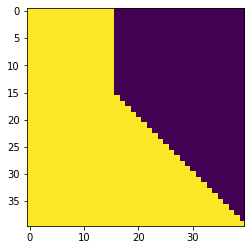

In [ ]:
plt.imshow(causal_mask[0,:,:])

### Training the model

In [ ]:
# Create a learning rate schedule
num_train_steps = len(train_data) * EPOCHS
num_warmup_steps = num_train_steps // EPOCHS

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Fit the model
history = caption_model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    callbacks=[early_stopping]
)

Epoch 1/10
4622/4622 [==============================] - 3176s 686ms/step - loss: 3.7340 - acc: 0.3315 - val_loss: 2.3971 - val_acc: 0.5180
Epoch 2/10
4622/4622 [==============================] - 3166s 685ms/step - loss: 2.1984 - acc: 0.5301 - val_loss: 2.1042 - val_acc: 0.5489
Epoch 3/10
4622/4622 [==============================] - 3165s 685ms/step - loss: 1.9922 - acc: 0.5577 - val_loss: 2.0216 - val_acc: 0.5565
Epoch 4/10
4622/4622 [==============================] - 3166s 685ms/step - loss: 1.8785 - acc: 0.5726 - val_loss: 1.9784 - val_acc: 0.5627
Epoch 5/10
4622/4622 [==============================] - 3166s 685ms/step - loss: 1.7941 - acc: 0.5840 - val_loss: 1.9605 - val_acc: 0.5644
Epoch 6/10
4622/4622 [==============================] - 3166s 685ms/step - loss: 1.7243 - acc: 0.5938 - val_loss: 1.9501 - val_acc: 0.5662
Epoch 7/10
4622/4622 [==============================] - 3167s 685ms/step - loss: 1.6636 - acc: 0.6030 - val_loss: 1.9504 - val_acc: 0.5653
Epoch 8/10
4622/4622 [=====

### Examine training history

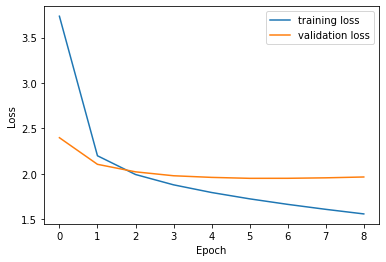

In [ ]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generate captions on test images

In [ ]:
def generate_caption(img_path, caption_model, print_caption = True, return_caption = False):
    index_word[VOCAB_SIZE] = '[IMAGE]'

    # Load raw image and embed with CLIP
    if img_path.endswith('.jpg') or img_path.endswith('.jpeg') or img_path.endswith('.png'):
        image = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        with torch.no_grad():
            embedded_img = clip_model.encode_image(image).cpu().numpy()

    # Load embeded image directly
    elif img_path.endswith('.npy'):
            embedded_img, _ = load_embedded(img_path,"")
            embedded_img = tf.expand_dims(embedded_img, axis=0)

    # Pass the image features to the Transformer encoder
    encoder_output = caption_model.encoder(embedded_img, training=False)
    prefix_length = tf.shape(encoder_output)[1]

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start>"
    for i in range(SEQ_LENGTH - 1):
        tokenized_caption = vectorization([decoded_caption])
        #tokenized_caption = tokenized_caption[:,:i+1]
        #print(tokenized_caption.shape)

        # concatenate dummy tokens for prefix and token
        caption_prefix = tf.concat([VOCAB_SIZE*tf.ones((1, prefix_length),dtype=tf.int64), tokenized_caption], axis=1)

        # shift to create input and target
        seq_inp = tokenized_caption[:, :-1]
        seq_true = caption_prefix[:, 1:]

        # obtain mask (0 is the pad token)
        mask = tf.math.not_equal(seq_true, 0)

        # pass thtought decoder
        predictions = caption_model.decoder(
            seq_inp, encoder_output, training=False, mask=mask
        )

        # extract predicted token (location: i + prefix_length - 1)
        sampled_token_index = np.argmax(predictions[0, i + prefix_length, :])
        sampled_token = index_word[sampled_token_index]
        #print(sampled_token)
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start>", "")
    decoded_caption = decoded_caption.replace("<end>", "").strip()
    if print_caption:
        print("Predicted Caption: ", decoded_caption)
    if return_caption:
        return decoded_caption


In [ ]:
# Generate captions for some ranomdly chosen images from the test data
for _ in range(15):
    rand_ind = np.random.choice(len(test_x))
    selected_img = test_x[rand_ind]
    if selected_img.endswith(".npy"):
        selected_img_path = os.path.join(IMAGE_PATH_flickr,selected_img.split('/')[-1][:-4]+'.jpg')
        if not os.path.exists(selected_img_path):
          selected_img_path = os.path.join(IMAGE_PATH_COCO,selected_img.split('/')[-1][:-4]+'.jpg')
          if not os.path.exists(selected_img_path):
            selected_img_path = os.path.join(IMAGE_PATH_COCO_VAL,selected_img.split('/')[-1][:-4]+'.jpg')

    image = cv2.imread(selected_img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    generate_caption(selected_img_path,caption_model)

Output hidden; open in https://colab.research.google.com to view.

#### Compute BLEU score on test images

In [ ]:
# collect referece sentences for each test image
test_data_group = []

for imgt in img_name_test_keys:
    these_caps = []
    for cap in img_to_cap_vector[imgt]:
        this_cap = []
        for idx in cap.numpy():
            if idx not in [0, word_index['<start>'], word_index['<end>'], word_index['[UNK]']]:
                this_cap.append(index_word[idx])
        these_caps.append(this_cap)
    test_data_group.append([imgt, these_caps])

In [ ]:
# compute BLEU scores on 1000 test images
num_examples = 1000
bleu1 = np.zeros(num_examples)
bleu2 = np.zeros(num_examples)
bleu3 = np.zeros(num_examples)
bleu4 = np.zeros(num_examples)

for i_img, (selected_img_path, ref_caps) in enumerate(test_data_group[:num_examples]):
    pred_cap = generate_caption(selected_img_path, caption_model, return_caption=True, print_caption=False).split()
    bleu1[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1, 0, 0, 0))
    bleu2[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.5, 0.5, 0, 0))
    bleu3[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1/3, 1/3, 1/3, 0))
    bleu4[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.25, 0.25, 0.25, 0.25))

print('Mean BLEU-1 = ', bleu1.mean())
print('Mean BLEU-2 = ', bleu2.mean())
print('Mean BLEU-3 = ', bleu3.mean())
print('Mean BLEU-4 = ', bleu4.mean())

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean BLEU-1 =  0.7464325587734558
Mean BLEU-2 =  0.5861524057301887
Mean BLEU-3 =  0.5140348159080813
Mean BLEU-4 =  0.5263027249999225


In [ ]:
# compute BLEU scores on all test data (takes a long time to run)
n_test_img = len(test_data_group)
bleu1 = np.zeros(n_test_img)
bleu2 = np.zeros(n_test_img)
bleu3 = np.zeros(n_test_img)
bleu4 = np.zeros(n_test_img)

for i_img, (selected_img_path, ref_caps) in enumerate(test_data_group):
    pred_cap = generate_caption(selected_img_path, caption_model, return_caption=True, print_caption=False).split()
    bleu1[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1, 0, 0, 0))
    bleu2[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.5, 0.5, 0, 0))
    bleu3[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1/3, 1/3, 1/3, 0))
    bleu4[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.25, 0.25, 0.25, 0.25))

print('Mean BLEU-1 = ', bleu1.mean())
print('Mean BLEU-2 = ', bleu2.mean())
print('Mean BLEU-3 = ', bleu3.mean())
print('Mean BLEU-4 = ', bleu4.mean())

### Save vectorization and model weights

In [ ]:
## save vectorization
# Pickle the config and weights
pickle.dump({'config': vectorization.get_config(),
             'weights': vectorization.get_weights()},
             open("vectorization.pkl", "wb"))
pickle.dump({'weights': vectorization.get_weights()},
             open("vectorization_weights.pkl", "wb"))

In [ ]:
# save model weights
encoder.save_weights(os.path.join(MODEL_PATH,"encoder.h5"))
decoder.save_weights(os.path.join(MODEL_PATH,"decoder.h5"))
# caption_model.save_weights(os.path.join(MODEL_PATH,"caption_model.h5"))

In [ ]:
# encoder.save('encoder')
# decoder.save('decoder')

### Re-create vectorization and the model from saved weights

In [ ]:
## load saved vectorization
vectorization_weights = pickle.load(open("vectorization_weights.pkl", "rb"))

def custom_standardization(input_string):
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Initiate vectorization
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
# Call `adapt` with some dummy data 
vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
# Load weights from saved vectorization
vectorization.set_weights(vectorization_weights['weights'])

In [ ]:
# initiate a new model
encoder2 = TransformerEncoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, image_length=IMAGE_LENGTH, 
                              num_heads=NUM_HEADS, num_layers=NUM_ENC_LAYERS)
decoder2 = TransformerDecoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, 
                              num_heads=NUM_HEADS, num_layers=NUM_DEC_LAYERS)
caption_model2 = ImageCaptioningModel(encoder=encoder2, decoder=decoder2)

In [ ]:
# Call the models with an example image before loading weights
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
example_img = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
example_caption = ["<start> a surfer riding on his board <end>"]

# Pass the image to the CNN
image = clip_preprocess(Image.open(example_img)).unsqueeze(0).to(device)
with torch.no_grad():
    embedded_img = clip_model.encode_image(image).cpu().numpy()

# Pass the image features to the Transformer encoder
encoder_output = caption_model2.encoder(embedded_img, training=False)

# Generate the caption using the Transformer decoder
tokenized_caption = vectorization([example_caption])[:, :-1]

# concatenate dummy tokens for prefix and token
seq_prefix = tf.concat([VOCAB_SIZE*tf.ones((tokenized_caption.shape[0], encoder_output.shape[1]),dtype=tf.int64), tokenized_caption],1)

# shift to create input and target
seq_inp = tokenized_caption[:, :-1]
seq_true = seq_prefix[:, 1:]

# obtain mask (0 is the pad token)
mask = tf.math.not_equal(seq_true, 0)

# pass thtought decoder
seq_pred = caption_model2.decoder(seq_inp, encoder_output, training=False, mask=mask)



73728/64400 [==================================] - 0s 1us/step


In [ ]:
# load model weights
encoder2.load_weights(os.path.join(MODEL_PATH,"encoder.h5"))
decoder2.load_weights(os.path.join(MODEL_PATH,"decoder.h5"))
caption_model2 = ImageCaptioningModelPrefix(encoder=encoder2, decoder=decoder2)

In [ ]:
# Generate captions for ranomdly chosen images from the test data
for _ in range(30):
    rand_ind = np.random.choice(len(test_x))
    selected_img = test_x[rand_ind]
    if selected_img.endswith(".npy"):
        selected_img_path = os.path.join(IMAGE_PATH_flickr,selected_img.split('/')[-1][:-4]+'.jpg')
        if not os.path.exists(selected_img_path):
          selected_img_path = os.path.join(IMAGE_PATH_COCO,selected_img.split('/')[-1][:-4]+'.jpg')
          if not os.path.exists(selected_img_path):
            selected_img_path = os.path.join(IMAGE_PATH_COCO_VAL,selected_img.split('/')[-1][:-4]+'.jpg')

    image = cv2.imread(selected_img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    generate_caption2(selected_img_path,caption_model2)

Output hidden; open in https://colab.research.google.com to view.

## Distillation

This section performs distillation of the trained prefix model to another model with smaller architecture.

In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")

    def compile(self, optimizer, student_loss_fn, distillation_loss_fn, Lambda = 0.1):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn
      self.Lambda = Lambda

    def calculate_student_loss(self, y_true, y_pred, mask):
        loss = self.student_loss_fn(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_student_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(tf.cast(y_true, dtype=tf.int32), tf.cast(tf.argmax(y_pred, axis=-1),dtype=tf.int32))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_distill_loss_and_acc(self, img_embed, batch_seq, training=True):
        # encoder image feature into prefix
        encoder_output_student = self.student.encoder(img_embed, training=training)
        prefix_length_student = self.student.encoder.image_length
        encoder_output_teacher = self.teacher.encoder(img_embed, training=False)
        prefix_length_teacher = self.teacher.encoder.image_length

        # concatenate dummy tokens for prefix (value = VOCAB_SIZE, i.e. 15000) and token
        batch_seq_prefix_student = tf.concat([VOCAB_SIZE*tf.ones((tf.shape(batch_seq)[0], prefix_length_student),dtype=tf.int64), batch_seq],1)
        batch_seq_prefix_teacher = tf.concat([VOCAB_SIZE*tf.ones((tf.shape(batch_seq)[0], prefix_length_teacher),dtype=tf.int64), batch_seq],1)

        # shift to create input and target
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true_student = batch_seq_prefix_student[:, 1:]
        batch_seq_true_teacher = batch_seq_prefix_teacher[:, 1:]

        # obtain mask (0 is the pad token)
        mask_student = tf.math.not_equal(batch_seq_true_student, 0)
        mask_teacher = tf.math.not_equal(batch_seq_true_teacher, 0)

        # pass through decoder
        batch_seq_pred_student = self.student.decoder(
            batch_seq_inp, encoder_output_student, training=training, mask=mask_student
        )

        batch_seq_pred_teacher = self.teacher.decoder(
            batch_seq_inp, encoder_output_teacher, training=False, mask=mask_teacher
        )

        # compute student loss
        student_loss = self.calculate_student_loss(batch_seq_true_student[:,prefix_length_student-1:], 
                                                   batch_seq_pred_student[:,prefix_length_student-1:,:], 
                                                   mask_student[:,prefix_length_student-1:])

        # compute distillation loss        
        distillation_loss = self.distillation_loss_fn(tf.reshape(batch_seq_pred_teacher[:,prefix_length_teacher-1:,:],[-1,VOCAB_SIZE+1]),
                                                      tf.reshape(batch_seq_pred_student[:,prefix_length_student-1:,:],[-1,VOCAB_SIZE+1]))

        # combine student loss and distillation loss
        loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        acc = self.calculate_student_accuracy(batch_seq_true_student[:,prefix_length_student-1:], 
                                              batch_seq_pred_student[:,prefix_length_student-1:,:],
                                              mask_student[:,prefix_length_student-1:])
        return loss, acc
    
    def _compute_student_loss_and_acc(self, img_embed, batch_seq, training=True):
        # encoder image feature into prefix
        encoder_output_student = self.student.encoder(img_embed, training=training)
        prefix_length_student = self.student.encoder.image_length

        # concatenate dummy tokens for prefix (value = VOCAB_SIZE, i.e. 15000) and token
        batch_seq_prefix_student = tf.concat([VOCAB_SIZE*tf.ones((tf.shape(batch_seq)[0], prefix_length_student),dtype=tf.int64), batch_seq],1)

        # shift to create input and target
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true_student = batch_seq_prefix_student[:, 1:]

        # obtain mask (0 is the pad token)
        mask_student = tf.math.not_equal(batch_seq_true_student, 0)

        # pass through decoder
        batch_seq_pred_student = self.student.decoder(
            batch_seq_inp, encoder_output_student, training=training, mask=mask_student
        )

        # compute student loss
        student_loss = self.calculate_student_loss(batch_seq_true_student[:,prefix_length_student-1:], 
                                                   batch_seq_pred_student[:,prefix_length_student-1:,:], 
                                                   mask_student[:,prefix_length_student-1:])

        acc = self.calculate_student_accuracy(batch_seq_true_student[:,prefix_length_student-1:], 
                                              batch_seq_pred_student[:,prefix_length_student-1:,:],
                                              mask_student[:,prefix_length_student-1:])
        return student_loss, acc

    def train_step(self, batch_data):
        batch_img_embed, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # pass each the captions to the decoder along with the encoder outputs 
        # and compute the loss as well as accuracy for each caption
        with tf.GradientTape() as tape:
            loss, acc = self._compute_distill_loss_and_acc(
                batch_img_embed, batch_seq, training=True
            )

            # update loss and accuracy
            batch_loss += loss
            batch_acc += acc

        # get the list of all the trainable weights
        train_vars = (
            self.student.encoder.trainable_variables + self.student.decoder.trainable_variables
        )

        # compute gradients
        grads = tape.gradient(loss, train_vars)

        # update trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))

        # update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # return loss and accuracy
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img_embed, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0


        # pass each the captions to the decoder along with the encoder outputs 
        # and compute the loss as well as accuracy for each caption
        student_loss, acc = self._compute_student_loss_and_acc(
            batch_img_embed, batch_seq, training=False
        )

        # update batch loss and batch accuracy
        batch_loss += student_loss
        batch_acc += acc

        # update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # return loss and accuracy
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

Build teacher and student model

In [ ]:
# Clear tensorflow session before training
tf.keras.backend.clear_session()

In [ ]:
# build teacher model
encoder_teacher = TransformerEncoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, image_length=IMAGE_LENGTH, 
                                     num_heads=NUM_HEADS, num_layers=NUM_ENC_LAYERS) 
decoder_teacher = TransformerDecoderPrefix(embed_dim=EMBED_DIM, ff_dim=FF_DIM, 
                                           num_heads=NUM_HEADS, num_layers=NUM_DEC_LAYERS)

In [ ]:
## Pass one batch of data to initiate the variables of the model
# encode image feature
encoder_output_teacher = encoder_teacher(embeded)

# concatenate dummy tokens for prefix and token
batch_seq_prefix_teacher = tf.concat([VOCAB_SIZE*tf.ones((label.shape[0], encoder_output_teacher.shape[1]),dtype=tf.int64), label],1)

# shift to create input and target
batch_seq_inp = label[:, :-1]
batch_seq_true_teacher = batch_seq_prefix_teacher[:, 1:]

# obtain mask (0 is the pad token)
mask_teacher = tf.math.not_equal(batch_seq_true_teacher, 0)

# pass thtought decoder
batch_seq_pred_teacher = decoder_teacher(batch_seq_inp, encoder_output_teacher, training=False, mask=mask_teacher)

In [ ]:
# load saved model weights
encoder_teacher.load_weights(os.path.join(MODEL_PATH,"encoder.h5"))
decoder_teacher.load_weights(os.path.join(MODEL_PATH,"decoder.h5"))
caption_model_teacher = ImageCaptioningModelPrefix(encoder=encoder_teacher, decoder=decoder_teacher)

In [ ]:
# Initiate student model
IMAGE_LENGTH_STUDENT = 10
NUM_HEADS_STUDENT = 8
NUM_ENC_LAYERS_STUDENT = 1
NUM_DEC_LAYERS_STUDENT = 3
encoder_student = TransformerEncoder(embed_dim=EMBED_DIM, ff_dim=FF_DIM, image_length=IMAGE_LENGTH_STUDENT, 
                                     num_heads=NUM_HEADS_STUDENT, num_layers=NUM_ENC_LAYERS_STUDENT) 
decoder_student = TransformerDecoderPrefix(embed_dim=EMBED_DIM, ff_dim=FF_DIM, 
                                           num_heads=NUM_HEADS_STUDENT, num_layers=NUM_DEC_LAYERS_STUDENT)
caption_model_student = ImageCaptioningModelPrefix(encoder=encoder_student, decoder=decoder_student)

In [ ]:
## Pass one batch of data to initiate the variables of the model
# encode image feature
encoder_output_student = encoder_student(embeded)

# concatenate dummy tokens for prefix and token
batch_seq_prefix_student = tf.concat([VOCAB_SIZE*tf.ones((label.shape[0], encoder_output_student.shape[1]),dtype=tf.int64), label],1)

# shift to create input and target
batch_seq_inp = label[:, :-1]
batch_seq_true_student = batch_seq_prefix_student[:, 1:]

# obtain mask (0 is the pad token)
mask_student = tf.math.not_equal(batch_seq_true_student, 0)

# pass thtought decoder
batch_seq_pred_student = decoder_student(batch_seq_inp, encoder_output_student, training=False, mask=mask_student)

Training

In [ ]:
# Create a learning rate schedule
num_train_steps = len(train_data) * EPOCHS
num_warmup_steps = num_train_steps // EPOCHS

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

In [ ]:
# Build the distiller model
distiller_model = Distiller(teacher=caption_model_teacher, student=caption_model_student)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Loss
student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")
distillation_loss = keras.losses.CategoricalCrossentropy(from_logits=False)


# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    Lambda=0.5
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Distill teacher to student
distill_results = distiller_model.fit(
        train_data,
        epochs=EPOCHS,
        validation_data=validation_data, 
        callbacks=[early_stopping],
        verbose=1)


Epoch 1/10
4621/4621 [==============================] - 2484s 536ms/step - loss: 4.1738 - acc: 0.3221 - val_loss: 2.2913 - val_acc: 0.5277
Epoch 2/10
4621/4621 [==============================] - 2476s 536ms/step - loss: 2.7228 - acc: 0.5364 - val_loss: 2.0099 - val_acc: 0.5581
Epoch 3/10
4621/4621 [==============================] - 2479s 536ms/step - loss: 2.5691 - acc: 0.5641 - val_loss: 1.9348 - val_acc: 0.5659
Epoch 4/10
4621/4621 [==============================] - 2481s 537ms/step - loss: 2.5008 - acc: 0.5782 - val_loss: 1.8978 - val_acc: 0.5707
Epoch 5/10
4621/4621 [==============================] - 2482s 537ms/step - loss: 2.4575 - acc: 0.5882 - val_loss: 1.8745 - val_acc: 0.5736
Epoch 6/10
4621/4621 [==============================] - 2482s 537ms/step - loss: 2.4255 - acc: 0.5960 - val_loss: 1.8635 - val_acc: 0.5746
Epoch 7/10
4621/4621 [==============================] - 2482s 537ms/step - loss: 2.4001 - acc: 0.6032 - val_loss: 1.8559 - val_acc: 0.5754
Epoch 8/10
4621/4621 [=====

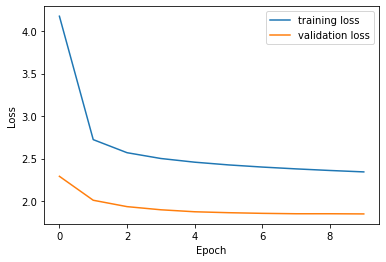

In [ ]:
plt.plot(distill_results.history['loss'],label='training loss')
plt.plot(distill_results.history['val_loss'],label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate captions for some ranomdly chosen images from the test data
for _ in range(15):
    rand_ind = np.random.choice(len(test_x))
    selected_img = test_x[rand_ind]
    if selected_img.endswith(".npy"):
        selected_img_path = os.path.join(IMAGE_PATH_flickr,selected_img.split('/')[-1][:-4]+'.jpg')
        if not os.path.exists(selected_img_path):
          selected_img_path = os.path.join(IMAGE_PATH_COCO,selected_img.split('/')[-1][:-4]+'.jpg')
          if not os.path.exists(selected_img_path):
            selected_img_path = os.path.join(IMAGE_PATH_COCO_VAL,selected_img.split('/')[-1][:-4]+'.jpg')

    image = cv2.imread(selected_img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    generate_caption(selected_img_path,caption_model_student)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# save model weights
DISTILL_MODEL_PATH = os.path.join(CURRENT_PATH,'distill_model')

if not os.path.exists(DISTILL_MODEL_PATH):
  os.mkdir(DISTILL_MODEL_PATH)

encoder_student.save_weights(os.path.join(DISTILL_MODEL_PATH,"encoder.h5"))
decoder_student.save_weights(os.path.join(DISTILL_MODEL_PATH,"decoder.h5"))


In [ ]:
# get index_word and word_index conversion
vocab = vectorization.get_vocabulary()
index_word = dict(zip(range(len(vocab)), vocab))
word_index = dict(zip(vocab, range(len(vocab))))

# collect referece sentences for each test image
test_data_group = []

for imgt in img_name_test_keys:
    these_caps = []
    for cap in img_to_cap_vector[imgt]:
        this_cap = []
        for idx in cap.numpy():
            if idx not in [0, word_index['<start>'], word_index['<end>'], word_index['[UNK]']]:
                this_cap.append(index_word[idx])
        these_caps.append(this_cap)
    test_data_group.append([imgt, these_caps])

In [ ]:
# compute BLEU scores on 1000 test images
num_examples = 1000
bleu1 = np.zeros(num_examples)
bleu2 = np.zeros(num_examples)
bleu3 = np.zeros(num_examples)
bleu4 = np.zeros(num_examples)

for i_img, (selected_img_path, ref_caps) in enumerate(test_data_group[:num_examples]):
    pred_cap = generate_caption(selected_img_path, caption_model_student, return_caption=True, print_caption=False).split()
    bleu1[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1, 0, 0, 0))
    bleu2[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.5, 0.5, 0, 0))
    bleu3[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(1/3, 1/3, 1/3, 0))
    bleu4[i_img] = sentence_bleu(ref_caps, pred_cap, weights=(0.25, 0.25, 0.25, 0.25))

print('Mean BLEU-1 = ', bleu1.mean())
print('Mean BLEU-2 = ', bleu2.mean())
print('Mean BLEU-3 = ', bleu3.mean())
print('Mean BLEU-4 = ', bleu4.mean())

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Mean BLEU-1 =  0.7479640860587753
Mean BLEU-2 =  0.584891442693589
Mean BLEU-3 =  0.520299872326856
Mean BLEU-4 =  0.5328800995959503
